# The Expedia Kaggle competition

Predicting what hotel that a user will book based on some attributes about the search the user is conducting on Expedia

This file is aim to go through the alogrithm showed in dataquest, which I did not develop it at all!

Based on https://www.dataquest.io/blog/kaggle-tutorial/

Data: https://www.kaggle.com/c/expedia-hotel-recommendations/data


In [1]:
# Import lib
import gzip
import numpy as np
import pandas as pd
import random

In [3]:
# Import data
destinations = pd.read_csv(gzip.open('/home/calvin/DS_projects/Expedia/zipped/destinations.csv.gz'))
test = pd.read_csv(gzip.open('/home/calvin/DS_projects/Expedia/zipped/test.csv.gz'))
train = pd.read_csv(gzip.open('/home/calvin/DS_projects/Expedia/zipped/train.csv.gz'), nrows= 3000000) # the data is too BIG to read all

In [4]:
print(destinations.shape, test.shape, train.shape)

(62106, 150) (2528243, 22) (3000000, 24)


In [5]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [6]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [8]:
# Exploring hotel clusters
train["hotel_cluster"].value_counts()

91    82461
41    62442
48    60104
64    58289
65    51539
5     49180
98    47585
59    45375
70    45023
42    43856
21    43762
18    42875
25    42782
46    42670
83    41835
62    41686
82    40971
95    40224
68    40119
28    39966
97    39888
37    39700
58    39562
9     38769
30    38665
50    38146
16    37551
2     36012
72    35861
99    35483
      ...  
79    22592
19    21995
38    21719
66    21436
67    20828
12    20672
23    20497
92    20265
43    20248
7     20110
54    20102
31    19818
87    19656
89    18925
49    18842
45    18828
80    17882
3     17731
93    17383
86    17286
60    17014
71    16668
14    15386
75    13420
24    13292
35    10843
53    10814
88     9041
27     8870
74     3762
dtype: int64

## Exploring train and test user ids

Check if all the TEST user ids are found in the TRAIN DataFrame. We can do this by finding the unique values for user_id in test, and seeing if they all exist in train.

Since we only read the first 50000 data from the training set so it should be false.

In [32]:
test_ids = set(test.user_id.unique())
train_ids = set(train.user_id.unique())
intersection_count = len(test_ids & train_ids)
intersection_count == len(test_ids)

False

In [33]:
# Add in times and dates
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,2014,8
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,2014,8
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,8250,1,0,1,2,50,628,1,2014,8
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,14984,1,0,1,2,50,1457,80,2014,8
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,14984,1,0,1,2,50,1457,21,2014,8


In [34]:
# Downsampling so that the dataframe only contains data from 10000 users
unique_users = train.user_id.unique()

# Take 10000 random sample from all user ID 
sel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 10000)) ]
sel_train = train[train.user_id.isin(sel_user_ids)]
sel_train.shape

(306010, 26)

In [35]:
# new training (t1) and testing sets (t2)
t1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]
t2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]
print(t1.shape, t2.shape)

(190278, 26) (115732, 26)


In [36]:
# Remove click events
t2 = t2[t2.is_booking == True]

# Algorithm #1
Base on the most common clusters across the data, then use them as predictions.

In [37]:
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)
predictions = [most_common_clusters for i in range(t2.shape[0])]
predictions[:5]
# Note that all the predictions are the same!

[[91, 41, 48, 64, 65],
 [91, 41, 48, 64, 65],
 [91, 41, 48, 64, 65],
 [91, 41, 48, 64, 65],
 [91, 41, 48, 64, 65]]

In [38]:
# Evaluating error
import ml_metrics as metrics
# (https://github.com/benhamner/Metrics/tree/master/Python)
target = [[l] for l in t2["hotel_cluster"]] # to convert into list because the function only work in list
metrics.mapk(target, predictions, k=5)


0.056225734886300602

# Finding correlations
To create an improved algorithm, we need to find correlations from the dataset first


In [39]:
train.corr()["hotel_cluster"]

site_name                   -0.021016
posa_continent               0.016214
user_location_country       -0.010261
user_location_region         0.008506
user_location_city           0.001433
orig_destination_distance    0.007119
user_id                      0.002861
is_mobile                    0.007536
is_package                   0.036257
channel                      0.000049
srch_adults_cnt              0.011057
srch_children_cnt            0.015163
srch_rm_cnt                 -0.007911
srch_destination_id         -0.011632
srch_destination_type_id    -0.033261
is_booking                  -0.022094
cnt                          0.003565
hotel_continent             -0.016308
hotel_country               -0.022291
hotel_market                 0.035289
hotel_cluster                1.000000
year                         0.000685
month                        0.001037
Name: hotel_cluster, dtype: float64

Here, no columns correlate linearly with hotel_cluster, this means that techniques like linear regression and logistic regression won’t work well on our data, because they rely on linear correlations between predictors and targets.

Furthermore, 

There are millions of rows, which increases runtime and memory usage for algorithms.

There are 100 different clusters, and according to the competition admins, the boundaries are fairly fuzzy, so it will likely be hard to make predictions. As the number of clusters increases, classifiers generally decrease in accuracy.

Nothing is linearly correlated with the target (hotel_clusters), meaning we can’t use fast machine learning techniques like linear regression.

# Machine learning probably won’t work well!!

# Generating features
Generate features from the destinations file

In [40]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


nb: There are 149 columns in the destination dataframe.

# Principal component analysis (PCA)
PCA will reduce the number of columns in a matrix while trying to preserve the same amount of variance per row. Ideally, PCA will compress all the information contained in all the columns into less, but in practice, some information is lost.

## Compresses the 149 columns in destinations down to 3 columns

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = destinations["srch_destination_id"]

In [42]:
dest_small.head()

,0,1,2,srch_destination_id
0,0.044268,-0.169419,-0.032522,0
1,0.440761,-0.077405,0.091572,1
2,-0.001033,-0.020677,-0.012108,2
3,0.480467,0.040345,0.019320,3
4,0.207253,0.042694,0.011744,4


## Generating features

Now that the preliminaries are done with, we can generate our features. We’ll do the following:

    1. Generate new date features based on date_time, srch_ci, and srch_co.
    2. Remove non-numeric columns like date_time.
    3. Add in features from dest_small.
    4. Replace any missing values with -1.


In [43]:
# Aim to calculate features such as length of stay, check in day, and check out month
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

df = calc_fast_features(t1)
df.fillna(-1, inplace=True)

/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [45]:
df.head()

,channel,ci_day,ci_dayofweek,ci_month,ci_quarter,cnt,co_day,co_dayofweek,co_month,co_quarter,...,srch_rm_cnt,stay_span,user_id,user_location_city,user_location_country,user_location_region,year,0,1,2
134,0,6,5,4,2,1,7,6,4,2,...,3,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005
135,0,6,5,4,2,1,7,6,4,2,...,2,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005
136,0,6,5,4,2,2,7,6,4,2,...,3,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005
137,0,6,5,4,2,1,7,6,4,2,...,3,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005
138,0,6,5,4,2,1,7,6,4,2,...,1,24,2140,23649,69,923,2013,-1.328761,-0.219954,-0.196005


# Machine learning

Use 3-fold cross validation across the training set to generate a reliable error estimate. 
Cross validation splits the training set up into 3 parts, then predicts hotel_cluster for each part using the other parts to train with.

## Random forests
Predictions using the Random Forest algorithm. Random forests build trees, which can fit to nonlinear tendencies in data

In [57]:
predictors = [c for c in df.columns if c not in ["hotel_cluster"]]
#print(np.size(predictors), df.shape)

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_validation.cross_val_score(clf, df[predictors], df['hotel_cluster'], cv=3)
scores

array([ 0.06539552,  0.06574591,  0.06541835])

The above code doesn’t give us very good accuracy, and confirms our original suspicion that machine learning isn’t a great approach to this problem. However, classifiers tend to have lower accuracy when there is a high cluster count. We can instead try training 100 binary classifiers. Each classifier will just determine if a row is in it’s cluster, or not. This will entail training one classifier per label in hotel_cluster.

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from itertools import chain

all_probs = []
unique_clusters = df["hotel_cluster"].unique()
for cluster in unique_clusters:
    df["target"] = 1
    df["target"][df["hotel_cluster"] != cluster] = 0
    predictors = [col for col in df if col not in ['hotel_cluster', "target"]]
    probs = []
    cv = KFold(len(df["target"]), n_folds=2)
    clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
    for i, (tr, te) in enumerate(cv):
        clf.fit(df[predictors].iloc[tr], df["target"].iloc[tr])
        preds = clf.predict_proba(df[predictors].iloc[te])
        probs.append([p[1] for p in preds])
    full_probs = chain.from_iterable(probs)
    all_probs.append(list(full_probs))

prediction_frame = pd.DataFrame(all_probs).T
prediction_frame.columns = unique_clusters
def find_top_5(row):
    return list(row.nlargest(5).index)

preds = []
for index, row in prediction_frame.iterrows():
    preds.append(find_top_5(row))

metrics.mapk([[l] for l in t2.iloc["hotel_cluster"]], preds, k=5)

/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/calvin/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning

TypeError: cannot do label indexing on <class 'pandas.core.index.Int64Index'> with these indexers [hotel_cluster] of <class 'str'>

Some errors occur when try to run the code provided. Nevertheless, the score is around 0.04 which is worse than before. It is confirmed that Machine Learning does not work in this problem.

#Top clusters based on hotel_cluster
We can first generate scores for each hotel_cluster in each srch_destination_id. We’ll weight bookings higher than clicks. This is because the test data is all booking data, and this is what we want to predict. We want to include click information, but downweight it to reflect this:

### 1. Group t1 by srch_destination_id, and hotel_cluster.

### 2. Iterate through each group, and:

* Assign 1 point to each hotel cluster where is_booking is True.

* Assign 0.15 points to each hotel cluster where is_booking is False.

* Assign the score to the srch_destination_id / hotel_cluster combination in a dictionary.


In [73]:
def make_key(items):
    return "_".join([str(i) for i in items])
match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = t1.groupby(cluster_cols)

top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

In [82]:
top_clusters

{'42991': {35: 0.15, 39: 0.3, 91: 1.15},
 '22864': {2: 4.25,
  9: 0.15,
  11: 0.15,
  12: 0.15,
  15: 3.5,
  22: 0.3,
  29: 0.6,
  30: 0.3,
  36: 0.44999999999999996,
  53: 0.15,
  57: 0.15,
  61: 0.3,
  62: 0.44999999999999996,
  64: 0.3,
  78: 0.15,
  81: 0.3,
  82: 0.44999999999999996,
  85: 0.3,
  97: 0.15},
 '12329': {46: 0.15},
 '25754': {23: 0.15},
 '3570': {91: 1.3},
 '34607': {32: 0.3, 55: 0.15},
 '12831': {38: 0.15, 60: 0.15, 61: 0.44999999999999996, 62: 0.15},
 '12836': {2: 0.3,
  4: 4.9,
  6: 1.3,
  10: 1.15,
  13: 0.15,
  14: 1.3,
  16: 1.3,
  18: 0.15,
  19: 0.15,
  21: 2.6,
  23: 0.44999999999999996,
  25: 0.44999999999999996,
  33: 0.15,
  39: 0.6,
  40: 0.15,
  41: 0.15,
  42: 0.15,
  49: 0.15,
  51: 0.3,
  68: 0.3,
  69: 0.15,
  72: 0.6,
  77: 2.45,
  83: 1.45,
  86: 0.15,
  91: 0.15,
  94: 0.15,
  95: 0.15,
  99: 0.15},
 '45480': {46: 0.44999999999999996},
 '12416': {53: 0.15},
 '21690': {30: 0.15,
  46: 0.15,
  61: 0.3,
  64: 0.15,
  81: 0.15,
  85: 0.44999999999999

In [64]:
# examples
fruits = ['apple', 'orange', 'mango']
make_key(fruits)

'apple_orange_mango'

In [85]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top
cluster_dict    

{'42991': [91, 39, 35],
 '22589': [22, 92],
 '12329': [46],
 '25754': [23],
 '34607': [32, 55],
 '12831': [61, 62, 60, 38],
 '12836': [4, 21, 77, 83, 6],
 '45480': [46],
 '12416': [53],
 '21690': [85, 61, 64, 81, 30],
 '33967': [72, 78, 13, 6, 61],
 '23708': [82],
 '8285': [25, 37, 11, 2, 22],
 '11535': [63],
 '30443': [21],
 '6606': [94],
 '11974': [13, 18, 91],
 '5956': [94, 48],
 '48040': [81, 78, 48, 2, 8],
 '1051': [23],
 '1014': [82, 92, 25, 75, 26],
 '1484': [12, 62, 30, 85],
 '48071': [15],
 '1654': [38, 81, 60, 85],
 '13438': [23, 50, 47, 77],
 '19752': [29, 78],
 '1769': [62, 81, 85],
 '20111': [58, 29],
 '19493': [76, 72, 42, 77, 16],
 '17366': [28, 30],
 '26613': [47],
 '28531': [3],
 '18863': [17, 51, 6, 89, 93],
 '25064': [77, 40, 17, 76, 18],
 '8215': [99, 46, 62, 10, 9],
 '4492': [40, 39, 57],
 '24370': [90],
 '11640': [34, 5, 53, 26, 44],
 '13172': [81, 49, 91, 94, 18],
 '33612': [38, 81, 53, 58, 20],
 '30332': [2, 55, 83, 10, 16],
 '24043': [30, 62, 85, 20, 58],
 '564

# Making predictions based on destination (srch_destination_id)

Once we know the top clusters for each srch_destination_id, we can quickly make predictions. To make predictions, all we have to do is:

* Iterate through each row in t2.

* Extract the srch_destination_id for the row.

* Find the top clusters for that destination id.

* Append the top clusters to preds.

In [88]:
preds = []
for index, row in t2.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])
preds

[[9, 68, 83, 41, 98],
 [37, 9, 41, 19, 68],
 [97, 8, 46, 13, 5],
 [70, 69, 55, 98, 56],
 [61, 33],
 [],
 [50, 33, 51, 83, 13],
 [0, 41, 96, 33, 83],
 [0, 96, 21, 41, 83],
 [47, 48, 91, 96, 40],
 [97, 9, 85, 99, 42],
 [64, 73, 25, 59, 58],
 [2, 25, 29, 58, 59],
 [71, 34, 0, 77, 84],
 [4, 70, 23, 95, 97],
 [18, 16, 48, 51, 49],
 [55, 91, 72, 68, 4],
 [68, 91, 28, 9, 48],
 [98, 70, 41, 55, 19],
 [4, 13, 49, 23, 28],
 [25, 28, 91, 59, 18],
 [],
 [28, 82, 50, 43, 13],
 [95, 18, 98, 21, 19],
 [59, 42, 93],
 [20, 30],
 [30],
 [],
 [4, 91, 18, 95, 42],
 [],
 [],
 [30],
 [95, 18, 98, 21, 19],
 [63, 81, 58, 36, 34],
 [29, 46, 12, 62, 36],
 [29, 46, 12, 62, 36],
 [33, 41, 16, 95, 49],
 [39, 13, 95, 77, 21],
 [32, 76, 43, 91, 39],
 [42, 91, 16, 77, 94],
 [36, 64, 97, 60, 2],
 [1, 79, 45, 24, 19],
 [64, 97, 8, 46, 7],
 [21, 98, 25, 64, 97],
 [1, 45, 24, 79, 88],
 [40, 23],
 [40, 23],
 [40, 23],
 [40, 23],
 [40, 23],
 [40, 23],
 [40, 23],
 [73, 40, 99],
 [42, 25, 4, 91, 28],
 [22, 30, 8, 43, 78],
 [

In [89]:
metrics.mapk([[l] for l in t2["hotel_cluster"]], preds, k=5)

0.23116432929244909

The score is much higher than those use machine learning, also note that:

* Different data locally and in the hidden set that leaderboard scores are computed on. For example, we’re computing error in a sample of the training set, and the leaderboard score is computed on the testing set.
* Techniques that result in higher accuracy with more training data. We’re only using a small subset of data for training, and it may be more accurate when we use the full training set.
* Different randomization. With certain algorithms, random numbers are involved, but we’re not using any of these.


# Finding matching users

There is a data leak that allows you to match users in the training set from the testing set using a set of columns including user_location_country, and user_location_region. [Post](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20345/data-leak)

i.e. We know the answer in trainning set, but we don't know the answer in testing set, so matching in this way we can creat a *cheat*!

The first step is to find users in the training set that match users in the testing set.

In order to do this, we need to:

*    Split the training data into groups based on the match columns.
*    Loop through the testing data.
*    Create an index based on the match columns.
*    Get any matches between the testing data and the training data using the groups.


In [90]:
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = t1.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(t2.shape[0]):
    exact_matches.append(generate_exact_matches(t2.iloc[i], match_cols))

# Combining predictions

We can combine different lists of predictions to boost accuracy. Doing so will also help us see how good our exact match strategy is. To do this, we’ll have to:

*    Combine exact_matches, preds, and most_common_clusters.
*    Only take the unique predictions, in sequential order, using the f5 function from here.
*    Ensure we have a maximum of 5 predictions for each row in the testing set.

Here’s how we can do it:

In [93]:
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result
    
full_preds = [f5(exact_matches[p] + preds[p] + most_common_clusters)[:5] for p in range(len(preds))]
metrics.mapk([[l] for l in t2["hotel_cluster"]], full_preds, k=5)

0.27298946200776486

# Making a Kaggle submission file

Luckily, because of the way we wrote the code, all we have to do to submit is assign train to the variable t1, and test to the variable t2. Then, we just have to re-run the code to make predictions. Re-running the code over the train and test sets should take less than an hour.

Once we have predictions, we just have to write them to a file:

In [ ]:
write_p = [" ".join([str(l) for l in p]) for p in full_preds]
write_frame = ["{0},{1}".format(t2["id"][i], write_p[i]) for i in range(len(full_preds))]
write_frame = ["id,hotel_clusters"] + write_frame
with open("predictions.csv", "w+") as f:
    f.write("\n".join(write_frame))

# Summary

We came a long way in this post! We went from just looking at the data all the way to creating a submission and getting onto the leaderboard. Along the way, some of the key steps we took were:

*    Exploring the data and understanding the problem.
*    Setting up a way to iterate quickly through different techniques.
*    Creating a way to figure out accuracy locally.
*    Reading the forums, scripts, and the descriptions of the contest very closely to better understand the structure of the data.
*    Trying a variety of techniques and not being afraid to not use machine learning.

These steps will serve you well in any Kaggle competition.

# Further improvements

In order to iterate quickly and explore techniques, speed is key. This is difficult with this competition, but there are a few strategies to try:

*    Sampling down the data even more.
*    Parallelizing operations across multiple cores.
*    Using Spark or other tools where tasks can be run on parallel workers.
*    Exploring various ways to write code and benchmarking to find the most efficient approach.
*    Avoiding iterating over the full training and testing sets, and instead using groups.

Writing fast, efficient code is a huge advantage in this competition.

# Future techniques to try

Once you have a stable foundation on which to run your code, there are a few avenues to explore in terms of techniques to boost accuracy:

*    Finding similarity between users, then adjusting hotel cluster scores based on similarity.
*    Using similarity between destinations to group multiple destinations together.
*    Applying machine learning within subsets of the data.
*    Combining different prediction strategies in a less naive way.
*    Exploring the link between hotel clusters and regions more.


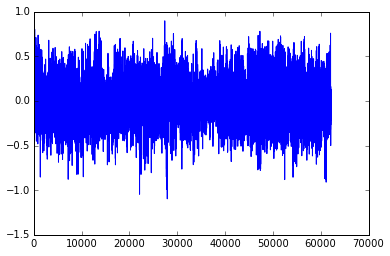

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dest_small.ix[:,2])